In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time


#needed to import utils.py
sys.path.append('../') 

import utils
import utils_preprocessing
import utils_exec_models

import numpy as np
import pandas as pd

from IPython.core.display import HTML

from IPython.display import clear_output


# Surpress warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)


%matplotlib inline  



### Read the performances obtained by GridSearch, and


In [2]:
csv_file = os.path.abspath('../05_Train_Validate_Models/exec_results/validation_results.csv')

df = utils.read_csv(csv_file)

cols_to_show = [
    'Scenario',
    'Model',
    'Estimator',
    'Valid_BalAcc',
    'Valid_Sens',
    'Valid_Spec',
#     'Valid_f1',
#     'Valid_AUC',
#     'Valid_Acc',
#     'Valid_Prec',
#     'Train_BalAcc',
#     'Train_Sens',
#     'Train_Spec',
#     'Train_f1',
#     'Train_AUC',
#     'Train_Acc',
#     'Train_Prec',
]

df[cols_to_show].head(3)

,Scenario,Model,Estimator,Valid_BalAcc,Valid_Sens,Valid_Spec
0,Single-Model,SVM,NaN,0.86,0.91,0.81
1,Single-Model,SVM,NaN,0.86,0.91,0.81
2,Single-Model,SVM,NaN,0.86,0.91,0.80


##### Auxiliary functions

In [43]:
def plot_barplot_with_performances_by_model_and_scenario(df, hatched_bars=False, 
            annotate=False, figsize=[20,20], sort_columns=None, graph_title=None,
            remove_model_from_y_label=False, col_group_name='Model and Scenario'):

    col_model = 'Model'
    col_scenario = 'Scenario'
    col_bacc = 'Valid_BalAcc'
    col_sens = 'Valid_Sens'
    col_spec = 'Valid_Spec'
#     col_auc  = 'Valid_AUC'
#     col_acc  = 'Valid_Acc'
#     col_prec  = 'Valid_Prec'
#     col_f1   = 'Valid_f1'
    
    if not remove_model_from_y_label:
        col_group = col_group_name
    else:
        col_group = 'Scenario'
    
    df_aux = df.copy()
    
    
    if sort_columns is None:
        sort_columns = [col_bacc, col_sens, col_spec]
    
    df_aux.sort_values(
        by=sort_columns, 
        ascending=False, 
        inplace=True,
    )
   
    
    if remove_model_from_y_label:
        df_aux[col_group] = df_aux[col_scenario]
    else:
        df_aux[col_group] = df_aux[col_model] + ' (' + df_aux[col_scenario] + ')'
    
    
    to_plot  =[
        ['Balanced Acc.', col_bacc],
        ['Sensitivity', col_sens],
        ['Specficity', col_spec],
#         ['AUC', col_auc],
#         ['f1 Score', col_f1],
#         ['Accuracy', col_acc],
#         ['Precision', col_prec],
    ]
    
    concat_dfs = []
    for desc, col in to_plot:
        # separate the each performance metric into dataFrames
        df_temp = df_aux[[col_group, col]].copy()
        df_temp.rename(columns={col: 'Performance'}, inplace=True)
        s_max = f' (max: {df_temp.Performance.max()})' if not annotate else ''
        df_temp['Metric'] = desc + s_max
        concat_dfs.append(df_temp)
        
    # concatenate all DFs
    df_graph = pd.concat(concat_dfs)

    # plot the graph
    plt.figure(figsize=figsize)
    ax = sns.barplot(
        data=df_graph, 
        x='Performance', 
        y=col_group, 
        hue='Metric',
        palette= sns.color_palette("colorblind") if not hatched_bars else None,
    )
    
    

    # if was to plot bar with hash instead of colors
    if hatched_bars:
        
#         hatches = [ "+" , "-", ".", "*","x", "o", "O"] #, "|" , "\\" , "/" ,  ]
        hatches = [ "|" , "\\" , "/" , "+" , "-", ".", "*","x", "o", "O" ]
        
        num_bars = 7
        i = 0
        for bar in ax.patches:
            if (i) % num_bars == 0:
                i = 0
            hatch = hatches[i]
            bar.set_hatch(hatch)
            bar.set_color('white')
            bar.set_edgecolor('black')
            i += 1
    
    
    # annotate the bars with their values
    if annotate and not hatched_bars:
        for p in ax.patches:
            ax.annotate(
                "%.2f" % p.get_width(), 
                xy=(
                    p.get_width()+ 0.015, 
                    p.get_y()+p.get_height()/2
                ),
                xytext=(5, 0), 
                textcoords='offset points', 
                ha="left", 
                va="center",
                size=10,
            )    


  
    plt.xlim(0, 1)
    plt.xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
    # red vertical line to highlight the performance threshold
    plt.axvline(x=0.8, color='r', ls=':', label='Performance Threshold')
    
    #place legend outside top right corner of plot
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

    if graph_title is not None:
        plt.title(graph_title)
    
    #
    plt.show()    
    plt.close()

    
    
    
    

    
    
# plot graph compraing 2 series    
def plot_side_by_side(df, filter_1, filter_2, col_to_filter, col_to_plot, cols_to_sort, ascending=True):
    
    df_1 = df.loc[(df[col_to_filter] == filter_1)].copy().sort_values(by=cols_to_sort, ascending=ascending)
    df_2 = df.loc[(df[col_to_filter] == filter_2)].copy().sort_values(by=cols_to_sort, ascending=ascending)

    utils.plot_series_side_by_side(
        series1=df_1[col_to_plot],
        series2=df_2[col_to_plot],
        title_list=[filter_1, filter_2],
    )

#     display(df_1[col_to_plot].value_counts())
#     display(df_2[col_to_plot].value_counts())
    
    
    
    
def plot_valid_training_comparison(dfs, scenarios):    

    for df_plot, scenario in zip(dfs, scenarios):
        y_train_line = df_plot.loc[(df_plot.Stage=='Train')][['Bal. Acc.', 'Sens.', 'Spec.']].values.ravel()
        y_valid_line = df_plot.loc[(df_plot.Stage=='Valid')][['Bal. Acc.', 'Sens.', 'Spec.']].values.ravel()
        
        utils.plot_performance_graph(
            y_train_line=y_train_line,
            y_valid_line=y_valid_line,
            scenario=scenario
        )
        
#             plt.figure(figsize=[3,2])
#             x = ['Bal. Acc.', 'Sens.', 'Spec.']#[1, 2, 3]
#             sns.lineplot(x=x,y=y_train_line, label='Training', linestyle='--', marker='o')
#             g = sns.lineplot(x=x,y=y_valid_line, label='Validation', marker='d')
#             sns.move_legend(g.axes, "upper left", bbox_to_anchor=(1, 1))
#             plt.ylim(0.6, 1.0)
#             plt.yticks([.6, .7, .8, .9, 1.])
#             plt.title(caption)
#             plt.show()    

## Plot the performances by Model and Scenario

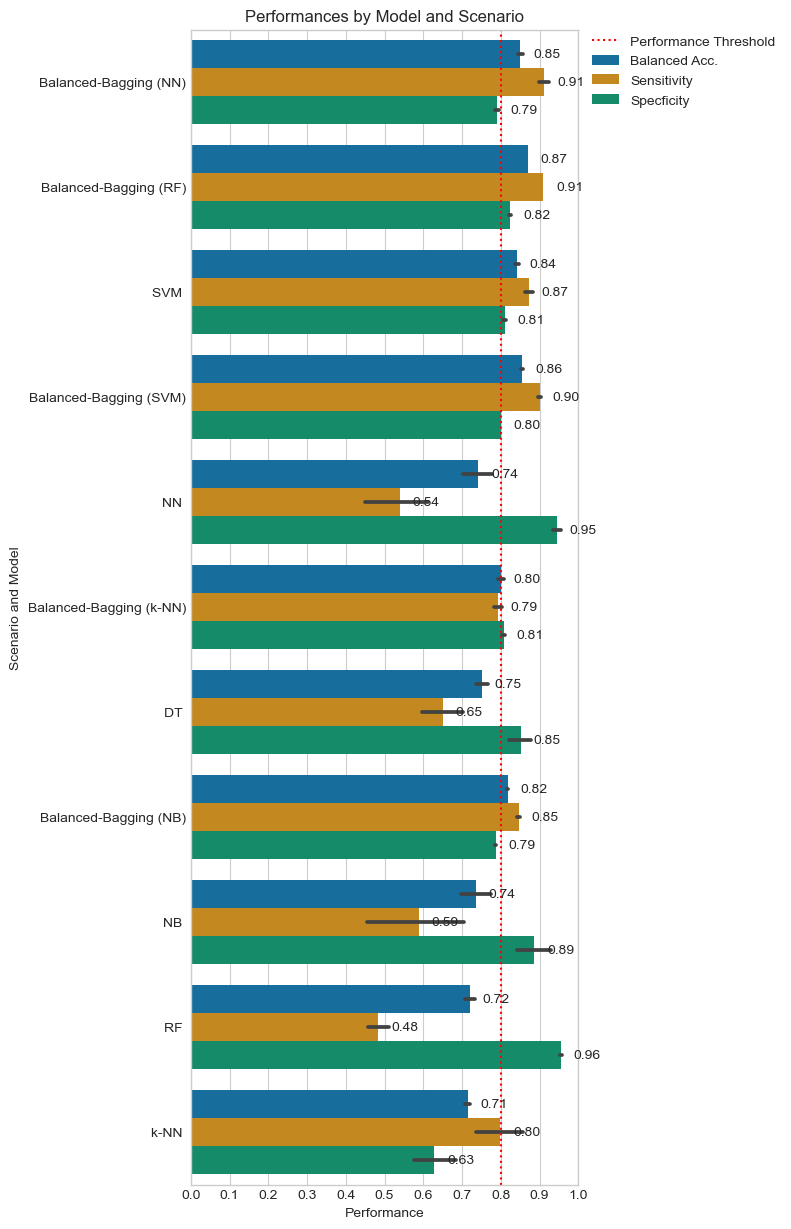

In [44]:
df_perf = utils_exec_models.plot_barplot_with_performances_by_model_and_scenario(
    df=df, 
    figsize=[5,15],
    annotate=True,
    graph_title='Performances by Model and Scenario',
    sort_columns=['Valid_BalAcc', 'Valid_Sens', 'Valid_Spec'],
)



---
## Check performances $\ge 0.80$ by `Dataset`


|Model|Balanced Data|Imbalanced Data|
|:-------|---------|-------|
|CatBoost|&check;  |       |
|NB      |&check;  |       |
|NN      |&check;  |       |
|SVM     |&check;  |&check;|
|DT      |         |&check;|
|XGBoost |         |       |
|k-NN    |         |       |
|RF      |         |       |



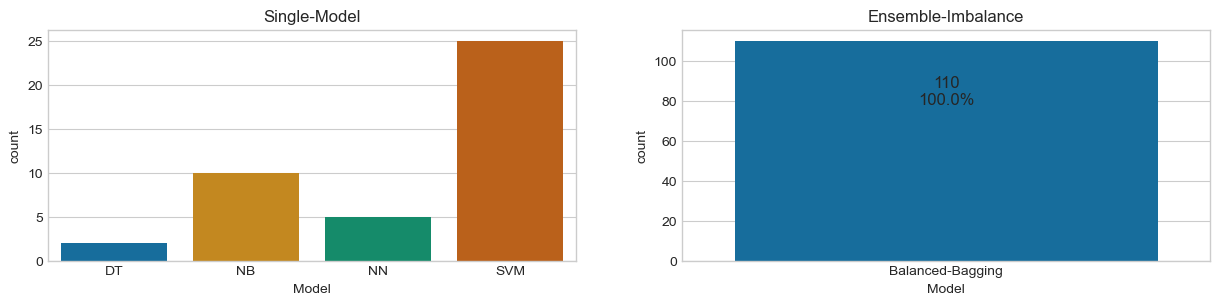

In [46]:
filter_1 = 'Single-Model'
filter_2 = 'Ensemble-Imbalance'
col_to_filter = 'Scenario'
col_to_plot = 'Model'
cols_to_sort = [col_to_plot]
ascending = True


df_performance_gt_80 = df.loc[(df.Valid_BalAcc >= 0.80)].copy()

plot_side_by_side(
    df=df_performance_gt_80, 
    filter_1=filter_1, 
    filter_2=filter_2, 
    col_to_filter=col_to_filter, 
    col_to_plot=col_to_plot, 
    cols_to_sort=cols_to_sort, 
    ascending=ascending,
)


---
## Check performances $\ge 0.80$ by `Features Set`


|Model|All Features|Feature Selection|
|:-------|---------|------|
|CatBoost|&check;  |&check; |
|NB      |&check;  |&check;|
|NN      |&check;  |&check;|
|SVM     |&check;  |&check;|
|DT      |         |&check;|
|XGBoost |         |       |
|k-NN    |         |       |
|RF      |         |       |


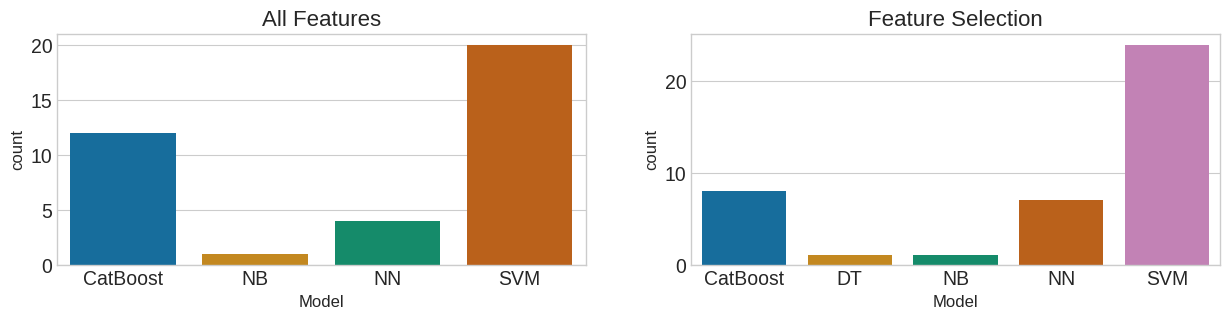

In [14]:
filter_1 = 'All Features'
filter_2 = 'Feature Selection'
col_to_filter = 'Features'
col_to_plot = 'Model'
cols_to_sort = [col_to_plot]
ascending = True


plot_side_by_side(
    df=df_performance_gt_80, 
    filter_1=filter_1, 
    filter_2=filter_2, 
    col_to_filter=col_to_filter, 
    col_to_plot=col_to_plot, 
    cols_to_sort=cols_to_sort, 
    ascending=ascending,
)


---
## Using $Balanced$ $Data$,  the models that obtained performance $\ge 0.80$ 

|Model|All Features|Feature Selection|
|---|---|---|
|CatBoost|&check;|&check; |
|NB|&check;|&check;|
|NN|&check;|&check;|
|SVM| |&check;|
|DT      |         |       |
|XGBoost |         |       |
|k-NN    |         |       |
|RF      |         |       |


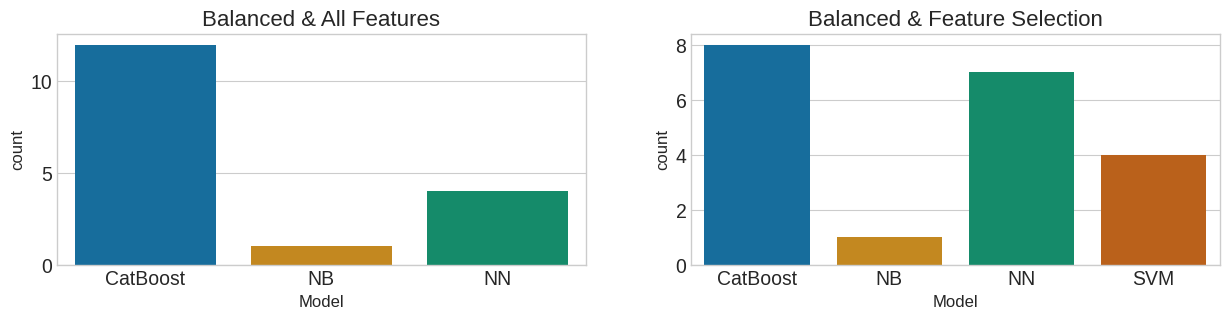

In [15]:
filter_1 = 'Balanced & All Features'
filter_2 = 'Balanced & Feature Selection'
col_to_filter = 'Extra_Info'
col_to_plot = 'Model'
cols_to_sort = [col_to_plot]
ascending = True

plot_side_by_side(
    df=df_performance_gt_80, 
    filter_1=filter_1, 
    filter_2=filter_2, 
    col_to_filter=col_to_filter, 
    col_to_plot=col_to_plot, 
    cols_to_sort=cols_to_sort, 
    ascending=ascending,
)


---
## Using $Imbalanced$ $Data$,  the models that obtained performance $\ge 0.80$ 

|Model   |All Features|Feature Selection|
|:-------|---------|-------|
|CatBoost|         |       |
|NB      |         |       |
|NN      |         |       |
|SVM     |&check;  |&check;|
|DT      |         |&check;|
|XGBoost |         |       |
|k-NN    |         |       |
|RF      |         |       |



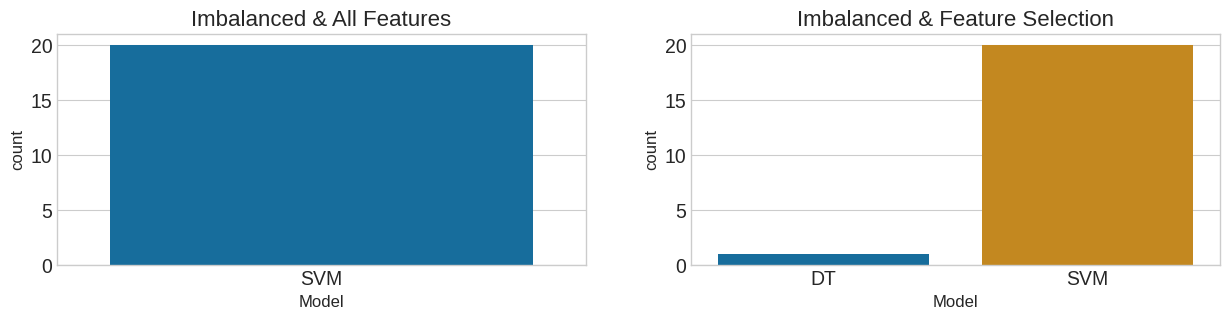

In [16]:
filter_1 = 'Imbalanced & All Features'
filter_2 = 'Imbalanced & Feature Selection'
col_to_filter = 'Extra_Info'
col_to_plot = 'Model'
cols_to_sort = [col_to_plot]
ascending = True

plot_side_by_side(
    df=df_performance_gt_80, 
    filter_1=filter_1, 
    filter_2=filter_2, 
    col_to_filter=col_to_filter, 
    col_to_plot=col_to_plot, 
    cols_to_sort=cols_to_sort, 
    ascending=ascending,
)



---
## Plot the best validation performances by $Model$ and $Scenario$ ($Dataset$ + $Features$)

|Model   |Balanced &<br/> All Features|<br/>Feature Selection|Imbalanced &<br/> All Features|<br/>Feature Selection|
|:-------|:-------:|:-----:|:-------:|:-----:|
|CatBoost|&check;  |&check;|         |       |
|NB      |&check;  |&check;|         |       |
|NN      |&check;  |&check;|         |       |
|SVM     |&check;  |&check;|&check;  |&check;|
|DT      |         |       |         |&check;|
|XGBoost |         |       |         |       |
|k-NN    |         |       |         |       |
|RF      |         |       |         |       |


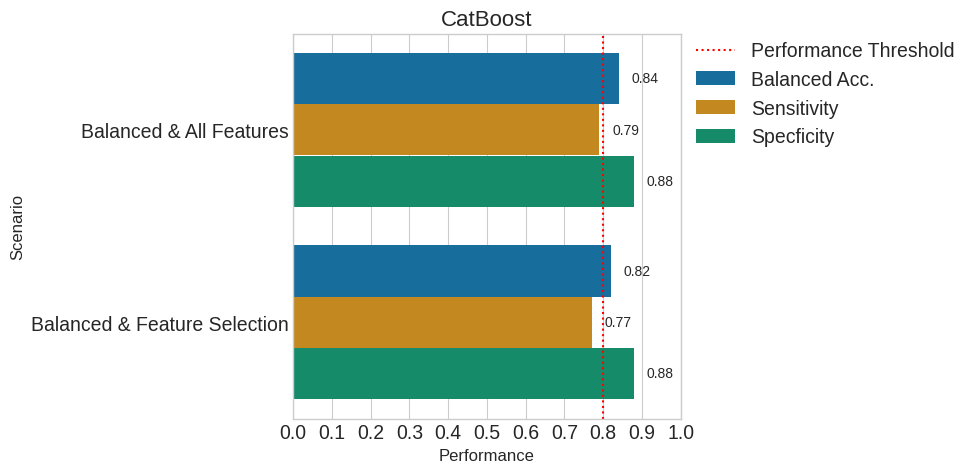

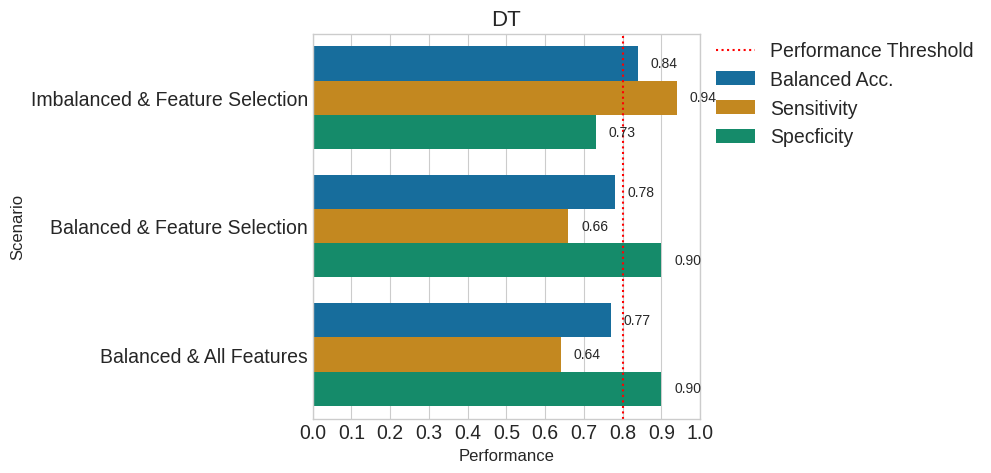

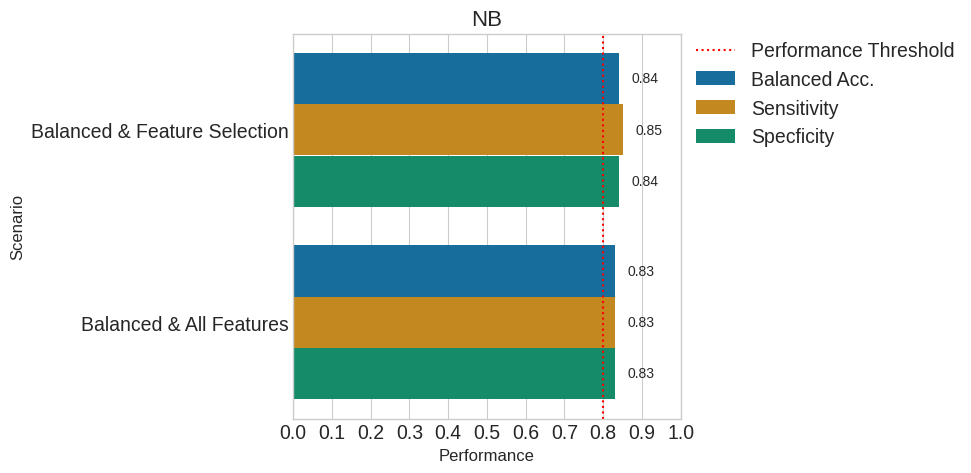

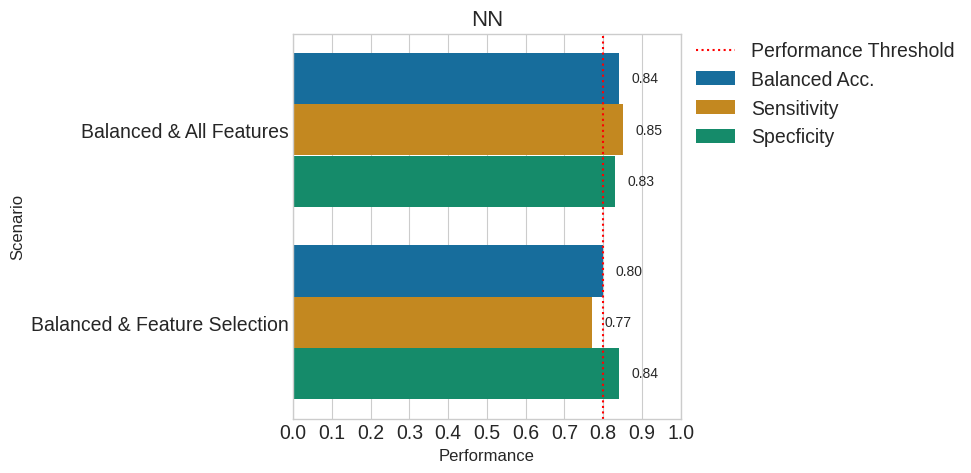

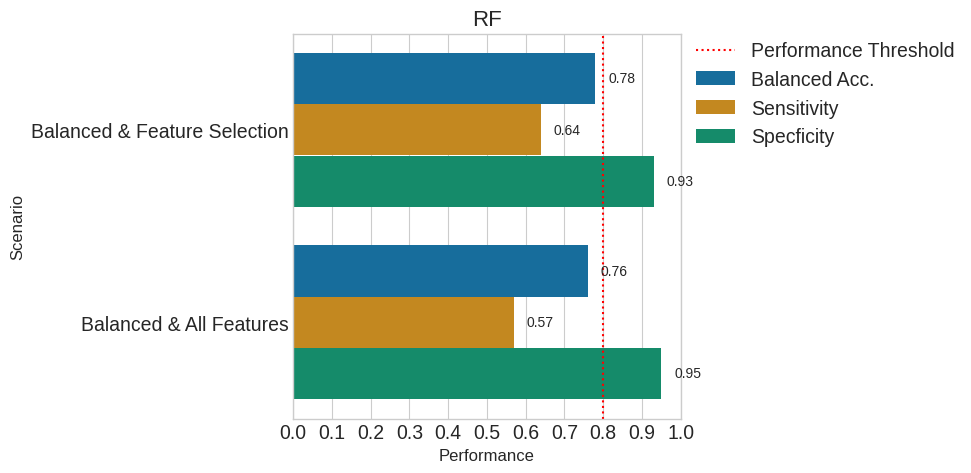

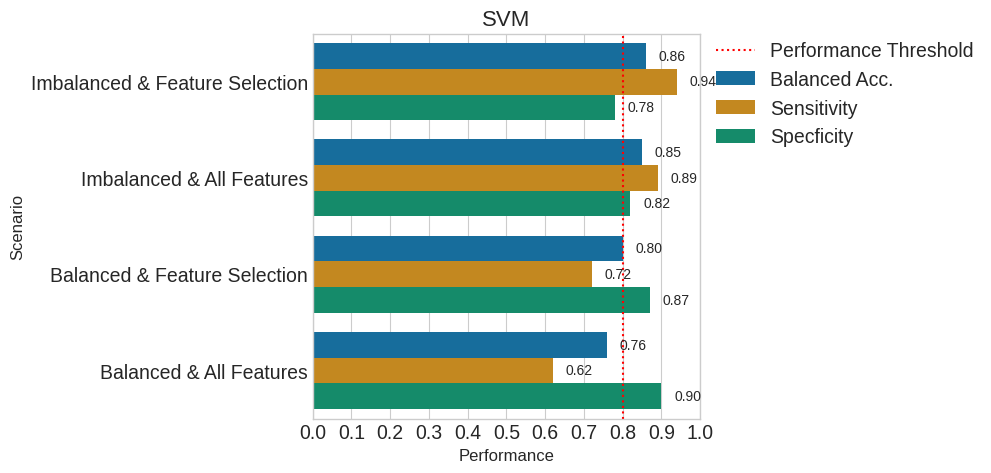

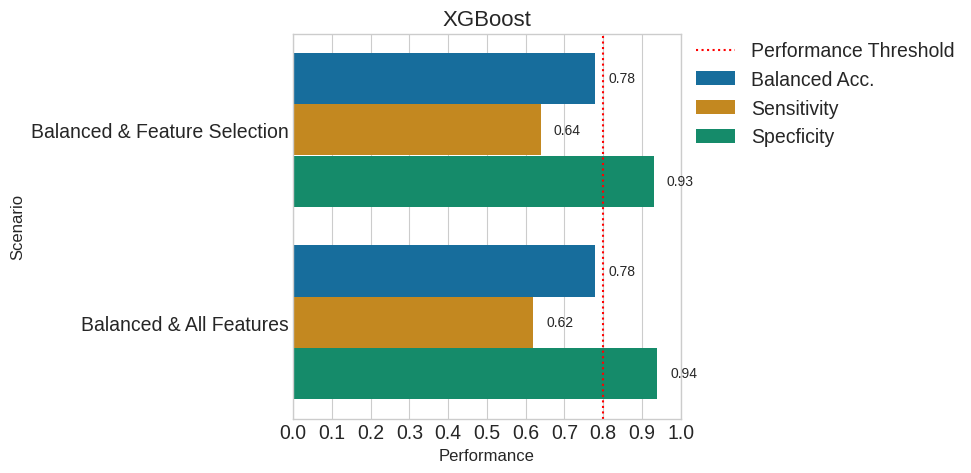

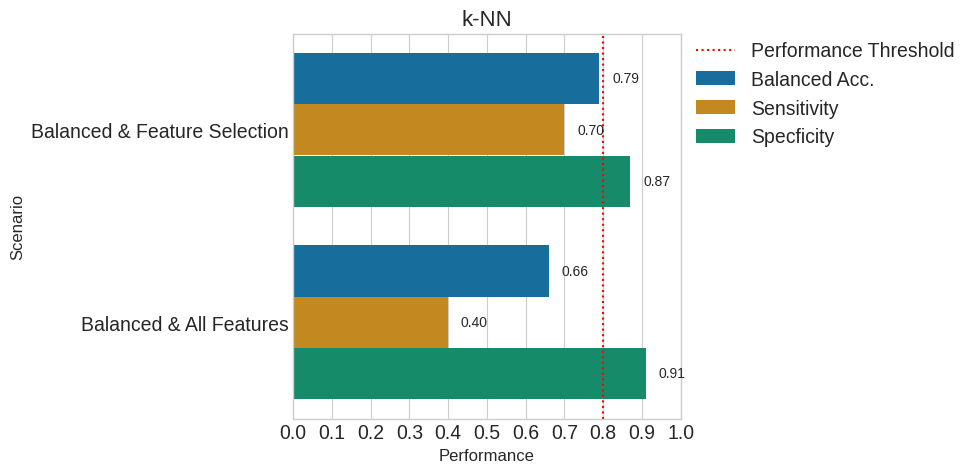

In [17]:
cols = [
    'Model',
    'Dataset',
    'Features',
    'Extra_Info',
    'Valid_BalAcc',
    'Valid_Sens',
    'Valid_Spec',
#     'Valid_AUC',
#     'Valid_f1',
#     'Valid_Acc',
#     'Valid_Prec',
]

df_best_valid = df[cols].copy()

df_best_valid = df_best_valid.groupby(by=['Model', 'Extra_Info']).first().reset_index()

# display(df_best_valid)

# models = sorted(df_aux.Model.unique())
models = df_best_valid.Model.unique()


# plot graphs for each model and scenario
for model in models:
    df_plot = df_best_valid.loc[(df_best_valid.Model == model)]
    plot_barplot_with_performances_by_model_and_scenario(
        df=df_plot,
        figsize=[5,5],
        annotate=True,
        graph_title=f'{model}',
        remove_model_from_y_label=True,
    )
    

---
---
# Plot $Training$ _vs._ $Validation$ performances

44


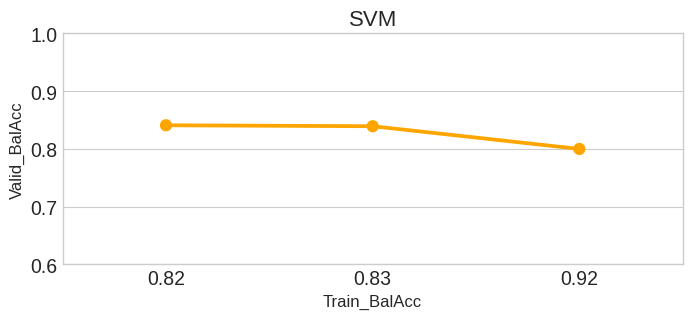

1


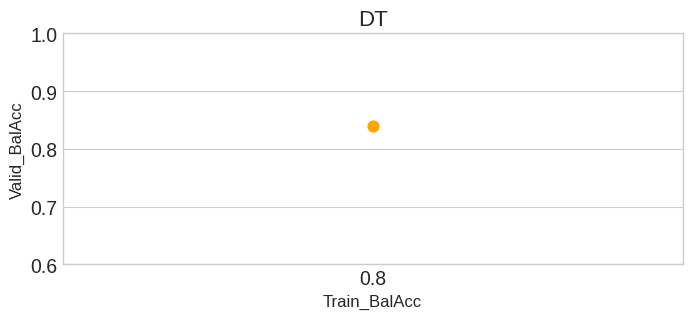

2


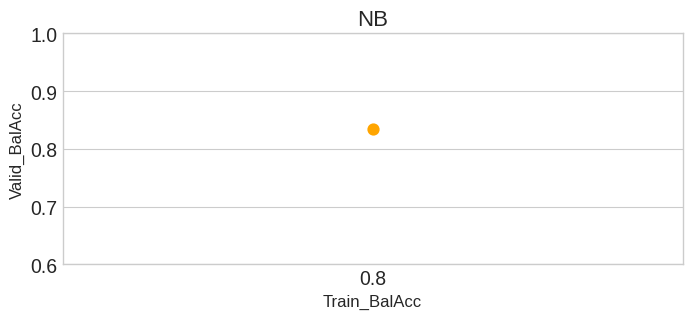

11


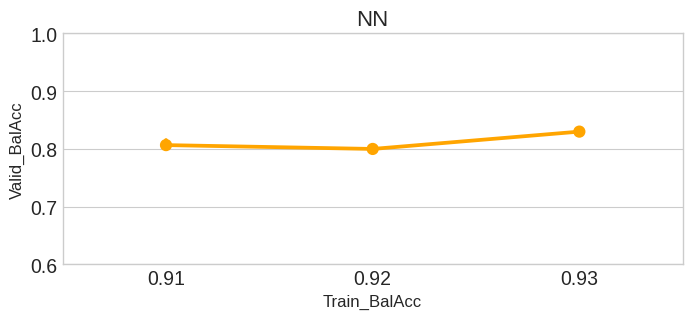

20


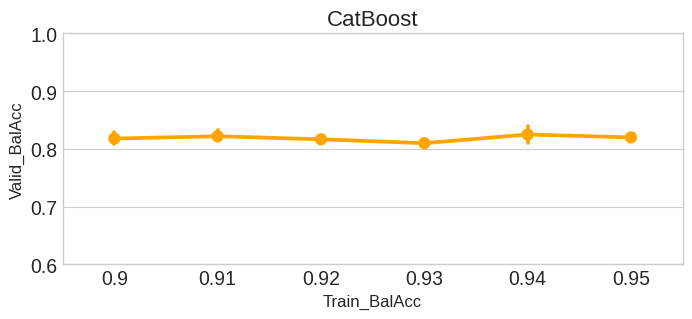

In [21]:
for model in df_performance_gt_80.Model.unique():
#     print(model)
    
    df_plot = df_performance_gt_80.loc[(df_performance_gt_80.Model==model)]
    df_plot = df_plot.sort_values(by=['Valid_BalAcc'])
    
    df_plot['bias']     = 1.0 - df_plot['Train_BalAcc']
    df_plot['variance'] = 1.0 - df_plot['Valid_BalAcc']
    df_plot['diff_bias_variance'] = df_plot['bias'] -  df_plot['variance'] 
    

    
    print(df_plot.shape[0])
    
    valid = df_plot.Valid_BalAcc.values
    train = df_plot.Train_BalAcc.values
    
    x = np.arange(0, len(valid))
    
    fig = plt.figure(figsize=[8, 3])
    
    
    x = 'Train_BalAcc'
    y = 'Valid_BalAcc' 
    ax = sns.pointplot(
        data=df_plot,
        x=x,
        y=y, 
        color='orange',
    )

#     x = 'Train_BalAcc'
#     y = 'Valid_BalAcc' 
#     ax = sns.pointplot(
#         x='Valid_BalAcc', 
#         y=train,
#         color='orange',
#     )

#     sns.pointplot(
#         x=x, 
#         y=valid,
#         color='black',
#         ax=ax
#     )

    
#     plt.xlim(0.0, 2.00)
    plt.ylim(0.60, 1.00)
    plt.title(model)
    
    plt.show()
    

#     cols = [x, y]
#     display(df_plot[cols])
    
    
#     break
    
    

    

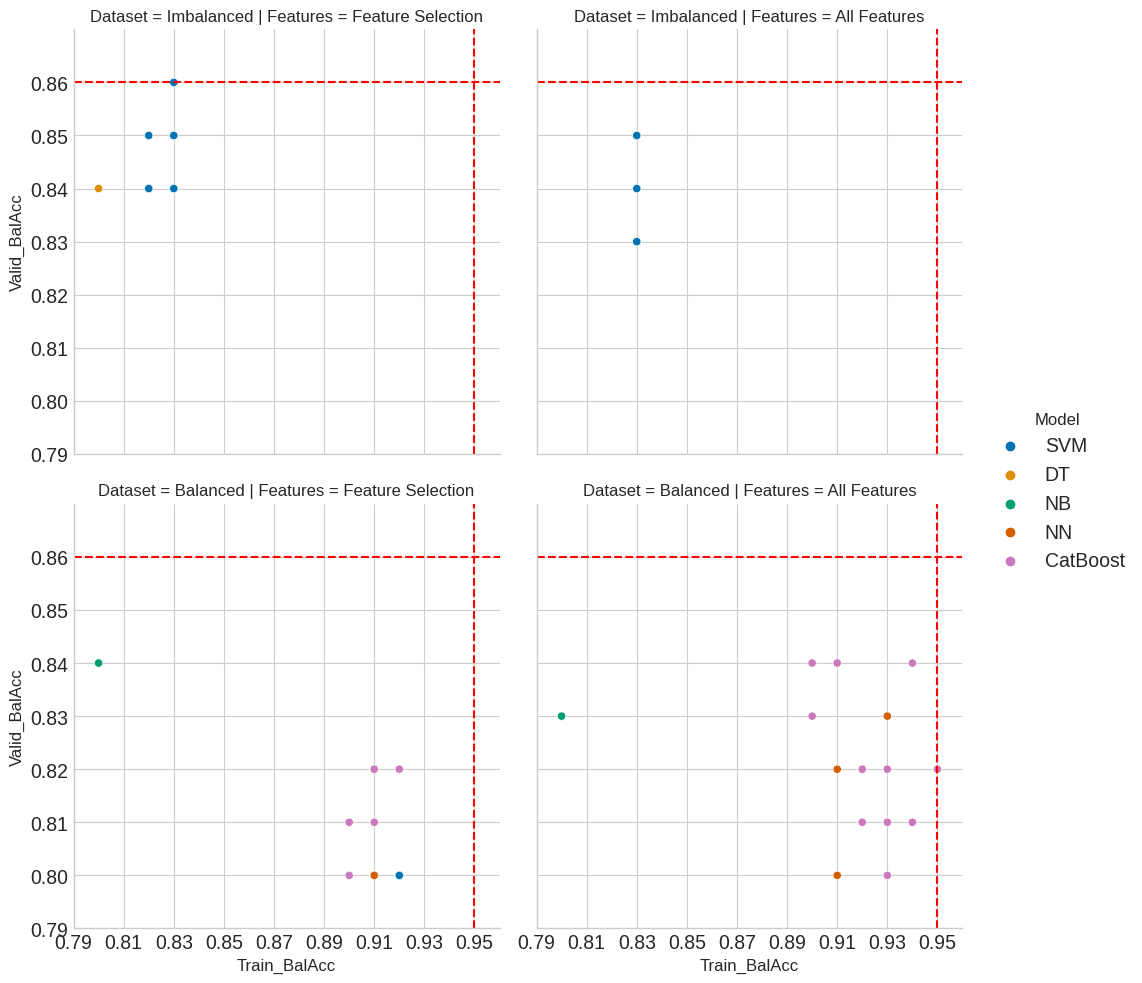

In [22]:
    
x = 'Train_BalAcc'
y = 'Valid_BalAcc' 


sns.set_palette('colorblind')
g = sns.relplot(
    data=df_performance_gt_80,
    x=x,
    y=y, 
    hue='Model',
    row='Dataset',
    col='Features',
)

x_min = df_performance_gt_80[x].min()-0.01
x_max = df_performance_gt_80[x].max()+0.01
x_ticks = np.arange(x_min, x_max, 0.02)

y_min = df_performance_gt_80[y].min()-0.01
y_max = df_performance_gt_80[y].max()+0.01
y_ticks = np.arange(y_min, y_max, 0.01)

plt.xticks(x_ticks)
plt.yticks(y_ticks)
plt.ylim(y_min, y_max)
plt.xlim(x_min, x_max)

g.refline(y=df_performance_gt_80[y].max(), color='red', linestyle='--')
g.refline(x=df_performance_gt_80[x].max(), color='red', linestyle='--')


---
## Show the best $Training$ performances by $Model$ and $Scenario$ 

### Prepare the data

In [23]:
csv_file = 'exec_results/results.csv'
df_results = utils.read_csv(csv_file)

df_results = df_results.groupby(
    by=['Model', 'Dataset', 'Features']#,'balanced_accuracy','sensitivity', 'specificity']
).head(20).reset_index(drop=True).sort_values(
    by=['BalAcc','Sens', 'Spec'],
    ascending=False,
).reset_index(drop=True)



# adjust the Dateset column values
df_results.Dataset = df_results.Dataset.replace('Training Balanced', 'Balanced')
df_results.Dataset = df_results.Dataset.replace('Training', 'Imbalanced')



keys = ['Classifier', 'Hyperparams', 'Dataset', 'Features']

# group-by to get best performances
df_results = df_results.groupby(by=keys).first().reset_index()

df_best_valid = df.copy()
df_best_valid = df_best_valid.groupby(by=keys).first().reset_index()


# join the datasets and reset the index
df_joined = df_results.set_index(keys).join(
    df_best_valid.set_index(keys),
    rsuffix='_validation', 
    how='left'
)

df_joined.reset_index(drop=False, inplace=True)

# update performances values for those not re-executed
to_update = df_joined.loc[(df_joined.Model_validation.isnull())]
df_joined.loc[to_update.index, 'Train_BalAcc'] = df_joined.BalAcc
df_joined.loc[to_update.index, 'Train_Sens'] = df_joined.Sens
df_joined.loc[to_update.index, 'Train_Spec'] = df_joined.Spec
df_joined.loc[to_update.index, 'Train_AUC'] = df_joined.AUC
df_joined.loc[to_update.index, 'Train_f1'] = df_joined.f1
df_joined.loc[to_update.index, 'Train_Acc'] = df_joined.Acc
df_joined.loc[to_update.index, 'Train_Prec'] = df_joined.Prec


### Show performances

In [24]:
df_aux = df_joined.copy()

df_aux = df_aux.groupby(by=['Model', 'Dataset', 'Features']).first().reset_index()

df_aux.rename(
    columns={
        'Train_BalAcc': 'Bal. Acc.', 
        'Train_Sens': 'Sens.', 
        'Train_Spec': 'Spec.', 
    }, inplace=True) 

cols_print = [
    'Bal. Acc.', 
    'Sens.', 
    'Spec.', 
]

models = df_aux.Model.unique()
datasets = df_aux.Dataset.unique()
features = df_aux.Features.unique()

# display performance as table for each model and scenario    
for model in models:
    dfs = []
    captions = []
    for dataset in datasets:
        for feature in features:
            df_temp = df_aux.loc[
                (df_aux.Model == model)
               &(df_aux.Dataset  == dataset)
               &(df_aux.Features == feature)
            ].copy()
            #            
            dfs.append(df_temp[cols_print])
            captions.append(f'{dataset} & <br>{feature}')
    
    
    display(HTML(f'<div style="border:2px solid gray">'))
    display(HTML(f'<h3>{model}</h3>'))
    output = utils.display_side_by_side(
        dfs=dfs, 
        captions=captions
    )
    display(HTML(output))
    display(HTML(f'</div>'))
    

Bal. Acc.,Sens.,Spec.
0.93,0.94,0.93
Bal. Acc.,Sens.,Spec.
0.91,0.91,0.90
Bal. Acc.,Sens.,Spec.
0.64,0.30,0.98
Bal. Acc.,Sens.,Spec.
0.62,0.26,0.99


Bal. Acc.,Sens.,Spec.
0.91,0.89,0.92
Bal. Acc.,Sens.,Spec.
0.92,0.91,0.92
Bal. Acc.,Sens.,Spec.
0.73,0.59,0.87
Bal. Acc.,Sens.,Spec.
0.73,0.60,0.85


Bal. Acc.,Sens.,Spec.
0.78,0.77,0.78
Bal. Acc.,Sens.,Spec.
0.78,0.79,0.77
Bal. Acc.,Sens.,Spec.
0.78,0.78,0.78
Bal. Acc.,Sens.,Spec.
0.77,0.75,0.78


Bal. Acc.,Sens.,Spec.
0.91,0.94,0.89
Bal. Acc.,Sens.,Spec.
0.92,0.95,0.89
Bal. Acc.,Sens.,Spec.
0.72,0.49,0.96
Bal. Acc.,Sens.,Spec.
0.72,0.49,0.95


Bal. Acc.,Sens.,Spec.
0.95,0.95,0.95
Bal. Acc.,Sens.,Spec.
0.94,0.94,0.94
Bal. Acc.,Sens.,Spec.
0.70,0.44,0.96
Bal. Acc.,Sens.,Spec.
0.71,0.47,0.94


Bal. Acc.,Sens.,Spec.
0.93,0.95,0.91
Bal. Acc.,Sens.,Spec.
0.92,0.94,0.89
Bal. Acc.,Sens.,Spec.
0.83,0.82,0.84
Bal. Acc.,Sens.,Spec.
0.83,0.83,0.83


Bal. Acc.,Sens.,Spec.
0.94,0.94,0.94
Bal. Acc.,Sens.,Spec.
0.94,0.93,0.94
Bal. Acc.,Sens.,Spec.
0.71,0.47,0.95
Bal. Acc.,Sens.,Spec.
0.73,0.50,0.96


Bal. Acc.,Sens.,Spec.
0.93,0.98,0.89
Bal. Acc.,Sens.,Spec.
0.92,0.96,0.87
Bal. Acc.,Sens.,Spec.
0.72,0.83,0.61
Bal. Acc.,Sens.,Spec.
0.74,0.76,0.71


---
## Show the best $Validation$ performances by $Model$ and $Scenario$ 

### Prepare the data and show the performances

In [25]:
csv_file = os.path.abspath('exec_results/validation_results.csv')

df_valid_perf = utils.read_csv(csv_file)

df_valid_perf.Dataset = df_valid_perf.Dataset.replace('Training Balanced', 'Balanced')
df_valid_perf.Dataset = df_valid_perf.Dataset.replace('Training', 'Imbalanced')

df_valid_perf['Extra_Info'] = df_valid_perf.Dataset + ' & '+ df_valid_perf.Features



df_valid_perf = df_valid_perf.groupby(by=['Model', 'Dataset', 'Features']).first().reset_index()

df_valid_perf.rename(
    columns={
        'Valid_BalAcc': 'Bal. Acc.', 
        'Valid_Sens': 'Sens.', 
        'Valid_Spec': 'Spec.', 
    }, inplace=True) 




## show the performances

cols_print = [
    'Bal. Acc.', 
    'Sens.', 
    'Spec.', 
]

models = df_valid_perf.Model.unique()
datasets = df_valid_perf.Dataset.unique()
features = df_valid_perf.Features.unique()

# display performance as table for each model and scenario    
cols_aux = ['Model', 'Bal. Acc.', 'Sens.', 'Spec.', 'Dataset', 'Features']    
for model in models:
    dfs = []
    captions = []
    for dataset in datasets:
        for feature in features:
            df_temp = df_valid_perf.loc[
                (df_valid_perf.Model == model)
               &(df_valid_perf.Dataset  == dataset)
               &(df_valid_perf.Features == feature)
            ].copy()
            
            if df_temp.shape[0] > 0:
                # get the long model description
                df_temp.Model = utils.get_model_description(model)
                #
                dfs.append(df_temp[cols_print])
                captions.append(f'{dataset} & <br>{feature}')

#                 print(model, dataset, feature)
#                 display(df_temp[cols_aux])


    model_desc = utils.get_model_description(model)
    display(HTML(f'<div style="border:2px solid gray">'))
    display(HTML(f'<h3>{model_desc}</h3>'))
    output = utils.display_side_by_side(
        dfs=dfs, 
        captions=captions
    )
    display(HTML(output))
    display(HTML(f'</div>'))

    
#     # gambiarra para exibir o 'Naïve Bayes' que sestá sem dados 
#     if model == 'DT':
#         empty_symbol = '--'
#         data = {
#             'Bal. Acc.': empty_symbol, 
#             'Sens.': empty_symbol, 
#             'Spec.': empty_symbol, 
#         }
#         display(HTML(f'<div style="border:2px solid gray">'))
#         display(HTML(f'<h3>Naïve Bayes</h3>'))
#         output = utils.display_side_by_side(
#             dfs=[pd.DataFrame(data, index=[0])], 
#             captions=captions
#         )
#         display(HTML(output))
#         display(HTML(f'</div>'))
    
    
# display(df_valid_perf[col# df_compare_train_valid.rename(



Bal. Acc.,Sens.,Spec.
0.84,0.79,0.88
Bal. Acc.,Sens.,Spec.
0.82,0.77,0.88


Bal. Acc.,Sens.,Spec.
0.77,0.64,0.90
Bal. Acc.,Sens.,Spec.
0.78,0.66,0.90
Bal. Acc.,Sens.,Spec.
0.84,0.94,0.73


Bal. Acc.,Sens.,Spec.
0.83,0.83,0.83
Bal. Acc.,Sens.,Spec.
0.84,0.85,0.84


Bal. Acc.,Sens.,Spec.
0.84,0.85,0.83
Bal. Acc.,Sens.,Spec.
0.80,0.77,0.84


Bal. Acc.,Sens.,Spec.
0.76,0.57,0.95
Bal. Acc.,Sens.,Spec.
0.78,0.64,0.93


Bal. Acc.,Sens.,Spec.
0.76,0.62,0.90
Bal. Acc.,Sens.,Spec.
0.80,0.72,0.87
Bal. Acc.,Sens.,Spec.
0.85,0.89,0.82
Bal. Acc.,Sens.,Spec.
0.86,0.94,0.78


Bal. Acc.,Sens.,Spec.
0.78,0.62,0.94
Bal. Acc.,Sens.,Spec.
0.78,0.64,0.93


Bal. Acc.,Sens.,Spec.
0.66,0.40,0.91
Bal. Acc.,Sens.,Spec.
0.79,0.70,0.87


---
## Compare $Training$ and  $Validation$ performances 

### Prepare the data and show the performances

Stage,Bal. Acc.,Sens.,Spec.
Train,0.91,0.91,0.91
Valid,0.84,0.79,0.88
Diff,-7%,-12%,-3%
Stage,Bal. Acc.,Sens.,Spec.
Train,0.91,0.91,0.91
Valid,0.82,0.77,0.88
Diff,-9%,-14%,-3%


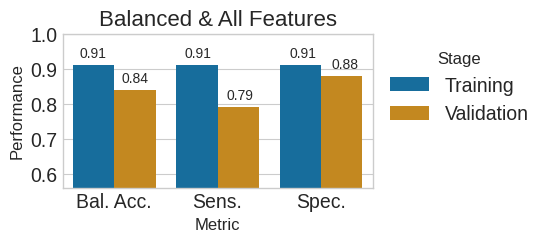

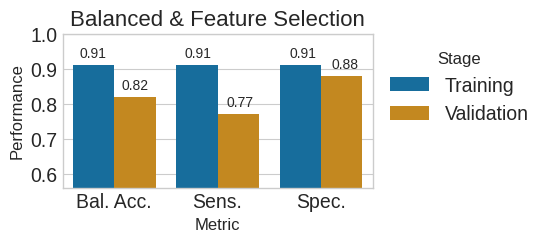

Stage,Bal. Acc.,Sens.,Spec.
Train,0.91,0.91,0.90
Valid,0.77,0.64,0.90
Diff,-14%,-27%,+0%
Stage,Bal. Acc.,Sens.,Spec.
Train,0.91,0.89,0.93
Valid,0.78,0.66,0.90
Diff,-13%,-23%,-3%
Stage,Bal. Acc.,Sens.,Spec.
Train,0.80,0.79,0.80
Valid,0.84,0.94,0.73


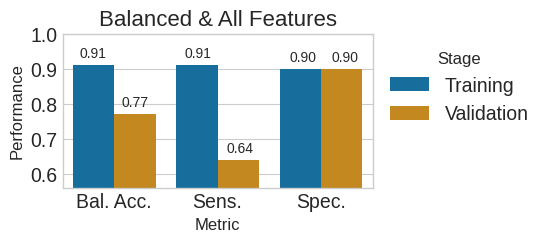

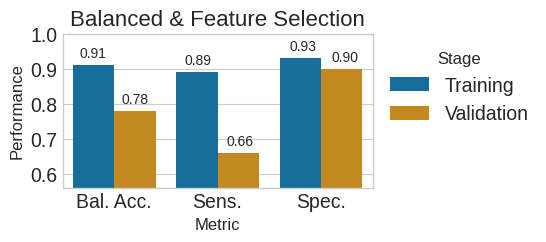

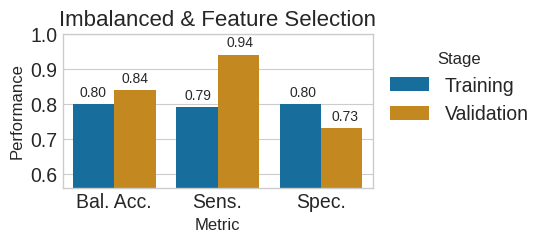

Stage,Bal. Acc.,Sens.,Spec.
Train,0.80,0.74,0.86
Valid,0.83,0.83,0.83
Diff,+2%,+8%,-3%
Stage,Bal. Acc.,Sens.,Spec.
Train,0.80,0.73,0.86
Valid,0.84,0.85,0.84
Diff,+3%,+12%,-2%


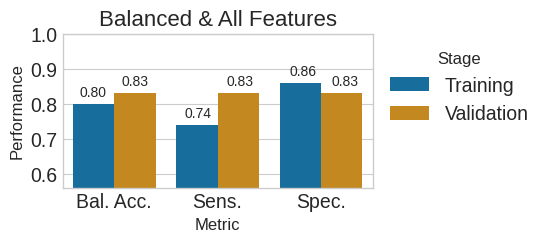

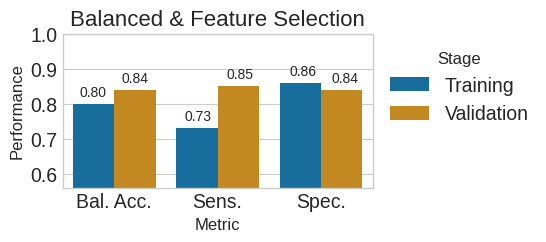

Stage,Bal. Acc.,Sens.,Spec.
Train,0.91,0.93,0.89
Valid,0.84,0.85,0.83
Diff,-7%,-8%,-6%
Stage,Bal. Acc.,Sens.,Spec.
Train,0.92,0.95,0.89
Valid,0.80,0.77,0.84
Diff,-12%,-17%,-5%


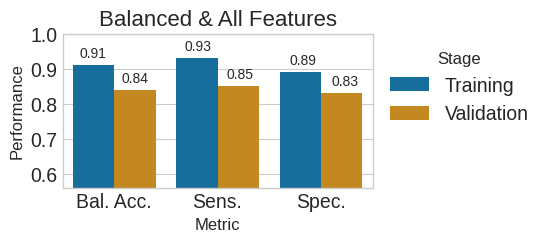

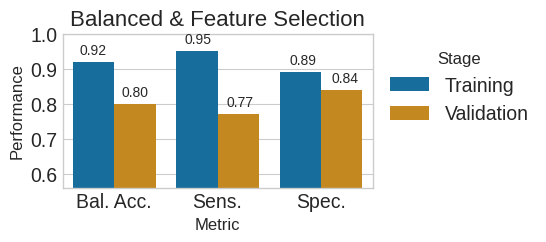

Stage,Bal. Acc.,Sens.,Spec.
Train,0.95,0.95,0.95
Valid,0.76,0.57,0.95
Diff,-18%,-38%,+0%
Stage,Bal. Acc.,Sens.,Spec.
Train,0.94,0.94,0.94
Valid,0.78,0.64,0.93
Diff,-15%,-29%,+0%


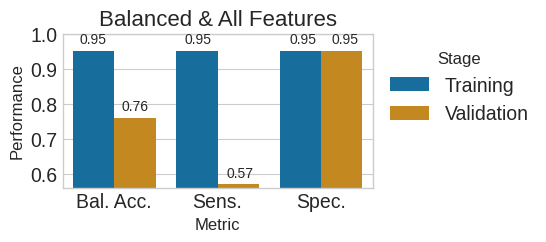

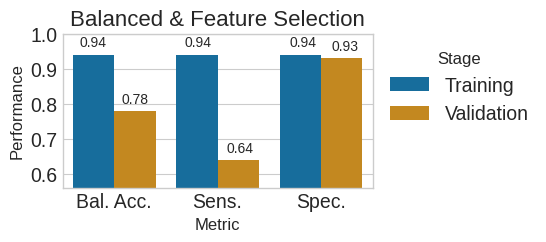

Stage,Bal. Acc.,Sens.,Spec.
Train,0.93,0.95,0.91
Valid,0.76,0.62,0.90
Diff,-17%,-32%,-1%
Stage,Bal. Acc.,Sens.,Spec.
Train,0.92,0.93,0.90
Valid,0.80,0.72,0.87
Diff,-12%,-21%,-3%
Stage,Bal. Acc.,Sens.,Spec.
Train,0.83,0.82,0.85
Valid,0.85,0.89,0.82


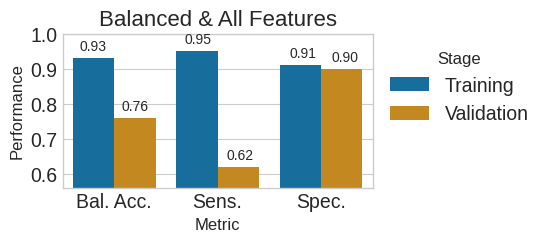

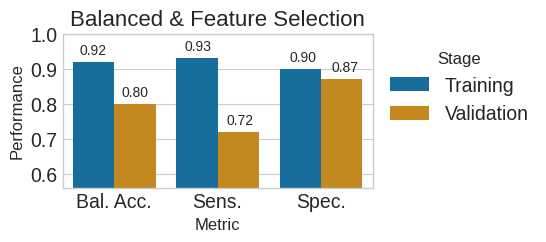

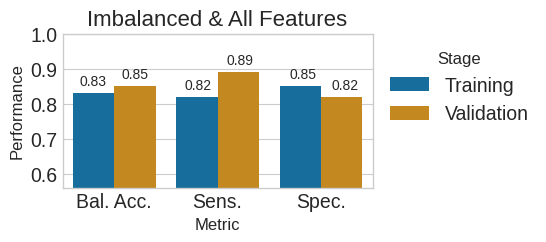

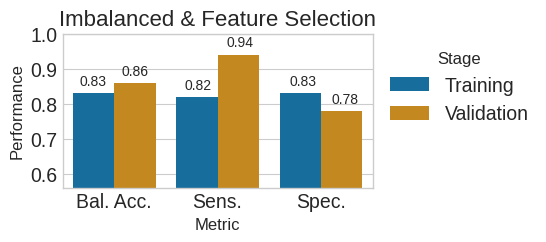

Stage,Bal. Acc.,Sens.,Spec.
Train,0.94,0.94,0.95
Valid,0.78,0.62,0.94
Diff,-15%,-31%,-1%
Stage,Bal. Acc.,Sens.,Spec.
Train,0.94,0.93,0.94
Valid,0.78,0.64,0.93
Diff,-15%,-29%,+0%


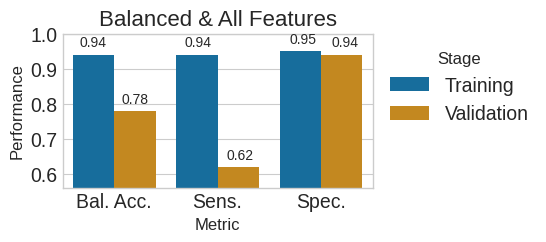

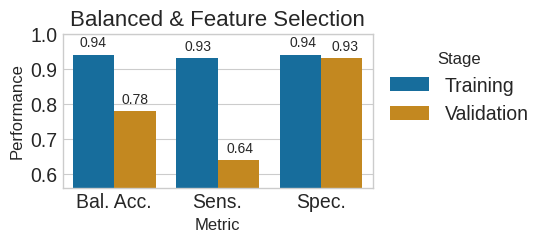

Stage,Bal. Acc.,Sens.,Spec.
Train,0.94,0.98,0.91
Valid,0.66,0.40,0.91
Diff,-27%,-57%,+0%
Stage,Bal. Acc.,Sens.,Spec.
Train,0.92,0.95,0.88
Valid,0.79,0.70,0.87
Diff,-13%,-25%,-1%


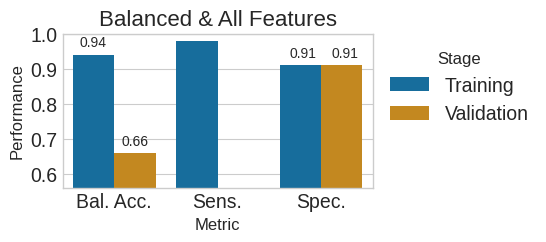

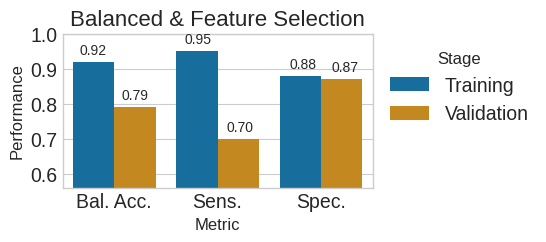

In [157]:
csv_file = os.path.abspath('exec_results/validation_results.csv')

df_compare_train_valid = utils.read_csv(csv_file)

df_compare_train_valid.Dataset = df_compare_train_valid.Dataset.replace('Training Balanced', 'Balanced')
df_compare_train_valid.Dataset = df_compare_train_valid.Dataset.replace('Training', 'Imbalanced')

# df_compare_train_valid.Features = df_compare_train_valid.Features.replace('All Features', 'All Feat.')
# df_compare_train_valid.Features = df_compare_train_valid.Features.replace('Feature Selection', 'Feat. Selection')

df_compare_train_valid['Extra_Info'] = df_compare_train_valid.Dataset + ' & '+ df_compare_train_valid.Features


df_compare_train_valid = df_compare_train_valid.groupby(by=['Model', 'Dataset', 'Features']).first().reset_index()



## show the performances

cols_print = [
    'Bal. Acc.', 
    'Sens.', 
    'Spec.', 
]

models = df_compare_train_valid.Model.unique()
datasets = df_compare_train_valid.Dataset.unique()
features = df_compare_train_valid.Features.unique()

# display performance as table for each model and scenario    
for model in models:
    dfs = []
    captions = []
    for dataset in datasets:
        for feature in features:
            df_temp = df_compare_train_valid.loc[
                (df_compare_train_valid.Model == model)
               &(df_compare_train_valid.Dataset  == dataset)
               &(df_compare_train_valid.Features == feature)
            ].copy()
            
            if df_temp.shape[0] > 0:

                
                
                data = {
                    'Stage': ['Train', 'Valid', 'Diff'], 
                    'Bal. Acc.': [
                        df_temp.Train_BalAcc.values[0], 
                        df_temp.Valid_BalAcc.values[0],
                        f'{int((df_temp.Valid_BalAcc.values[0] - df_temp.Train_BalAcc.values[0])*100):+}%'
                    ], 
                    'Sens.': [
                        df_temp.Train_Sens.values[0], 
                        df_temp.Valid_Sens.values[0],
                        f'{int((df_temp.Valid_Sens.values[0] - df_temp.Train_Sens.values[0])*100):+}%'
                    ], 
                    'Spec.': [
                        df_temp.Train_Spec.values[0], 
                        df_temp.Valid_Spec.values[0],
                        f'{int((df_temp.Valid_Spec.values[0] - df_temp.Train_Spec.values[0])*100):+}%'
                    ],
                }
                
                df_temp = pd.DataFrame(data)
                dfs.append(df_temp)
                
                captions.append(f'{dataset} & {feature}')


    model_desc = utils.get_model_description(model)
    display(HTML(f'<div style="border:2px solid gray">'))
    display(HTML(f'<h3>{model_desc}</h3>'))
    output = utils.display_side_by_side(
        dfs=dfs, 
        captions=captions
    )
    display(HTML(output))
    display(HTML(f'</div>'))

    plot_valid_training_comparison(dfs=dfs, scenarios=captions)




---
## Compare $Training$ and  $Validation$ performances, shown only $best$ performances with $Sensitivity$ $\ge 0.79$

Stage,Bal. Acc.,Sens.,Spec.
Train,0.91,0.91,0.91
Valid,0.84,0.79,0.88
Diff,-7%,-12%,-3%


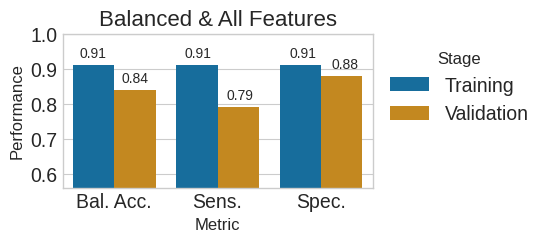

Stage,Bal. Acc.,Sens.,Spec.
Train,0.80,0.79,0.80
Valid,0.84,0.94,0.73
Diff,+3%,+14%,-7%


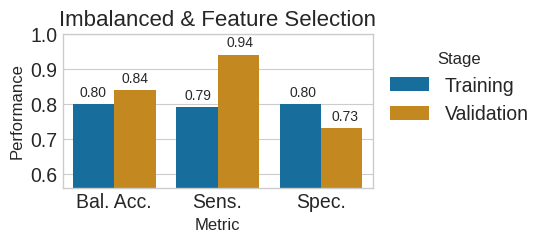

Stage,Bal. Acc.,Sens.,Spec.
Train,0.80,0.74,0.86
Valid,0.83,0.83,0.83
Diff,+2%,+8%,-3%
Stage,Bal. Acc.,Sens.,Spec.
Train,0.80,0.73,0.86
Valid,0.84,0.85,0.84
Diff,+3%,+12%,-2%


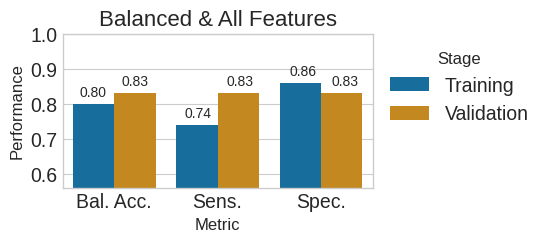

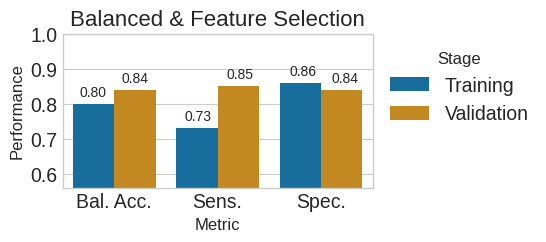

Stage,Bal. Acc.,Sens.,Spec.
Train,0.91,0.93,0.89
Valid,0.84,0.85,0.83
Diff,-7%,-8%,-6%


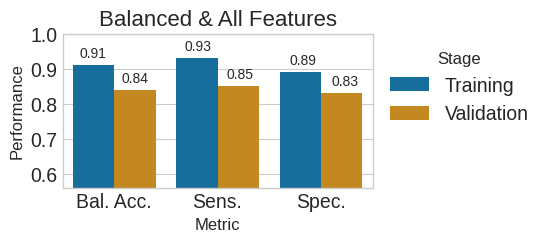

Stage,Bal. Acc.,Sens.,Spec.
Train,0.83,0.82,0.85
Valid,0.85,0.89,0.82
Diff,+2%,+7%,-3%
Stage,Bal. Acc.,Sens.,Spec.
Train,0.83,0.82,0.83
Valid,0.86,0.94,0.78
Diff,+3%,+12%,-4%


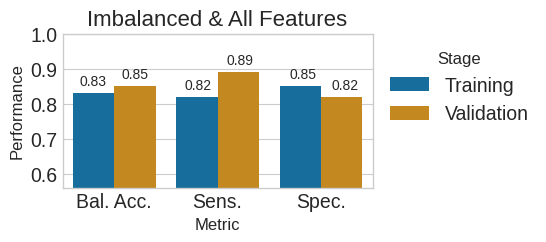

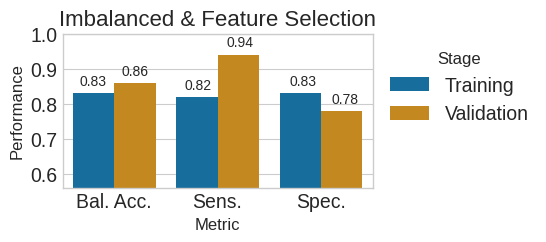

In [158]:
# display performance as table for each model and scenario    
for model in models:
    dfs = []
    captions = []
    for dataset in datasets:
        for feature in features:
            df_temp = df_compare_train_valid.loc[
                (df_compare_train_valid.Model == model)
               &(df_compare_train_valid.Dataset  == dataset)
               &(df_compare_train_valid.Features == feature)
            ].copy()
            
            if df_temp.shape[0] > 0:
                
                if float(df_temp.Valid_Sens) >= 0.79:
                    data = {
                        'Stage': ['Train', 'Valid', 'Diff'], 
                        'Bal. Acc.': [
                            df_temp.Train_BalAcc.values[0], 
                            df_temp.Valid_BalAcc.values[0],
                            f'{int((df_temp.Valid_BalAcc.values[0] - df_temp.Train_BalAcc.values[0])*100):+}%'
                        ], 
                        'Sens.': [
                            df_temp.Train_Sens.values[0], 
                            df_temp.Valid_Sens.values[0],
                            f'{int((df_temp.Valid_Sens.values[0] - df_temp.Train_Sens.values[0])*100):+}%'
                        ], 
                        'Spec.': [
                            df_temp.Train_Spec.values[0], 
                            df_temp.Valid_Spec.values[0],
                            f'{int((df_temp.Valid_Spec.values[0] - df_temp.Train_Spec.values[0])*100):+}%'
                        ],
                    }

                    df_temp = pd.DataFrame(data)
                    dfs.append(df_temp)

                    captions.append(f'{dataset} & {feature}')

    if len(dfs) > 0:
        model_desc = utils.get_model_description(model)
        display(HTML(f'<div style="border:2px solid gray">'))
        display(HTML(f'<h3>{model_desc}</h3>'))
        output = utils.display_side_by_side(
            dfs=dfs, 
            captions=captions
        )
        display(HTML(output))
        display(HTML(f'</div>'))
        
        plot_valid_training_comparison(dfs=dfs, scenarios=captions)
#         ppp(dfs, captions)
        
#     break

---
---
---

# OTHERS

---
## Compare $Training$ and  $Validation$ performances, showng only $best$ performances

In [108]:
def plot_performances_comparing_train_validation(df, model, annotate=True, figsize=[5,4]):
    df_temp = df.copy()
    
    data = [
        # Bal Acc
        {
            'Stage' : 'Training',
            'Metric': 'Bal. Acc.',
            'Performance': df_temp.Train_BalAcc.values[0] 
        },
        {
            'Stage' : 'Validation',
            'Metric': 'Bal. Acc.',
            'Performance': df_temp.Valid_BalAcc.values[0] 
        },
        # Sens
        {
            'Stage' : 'Training',
            'Metric': 'Sens.',
            'Performance': df_temp.Train_Sens.values[0] 
        },
        {
            'Stage' : 'Validation',
            'Metric': 'Sens.',
            'Performance': df_temp.Valid_Sens.values[0] 
        },                   
        # Spec
        {
            'Stage' : 'Training',
            'Metric': 'Spec.',
            'Performance': df_temp.Train_Spec.values[0] 
        },
        {
            'Stage' : 'Validation',
            'Metric': 'Spec.',
            'Performance': df_temp.Valid_Spec.values[0] 
        },                    
    ]

    df_plot = pd.DataFrame(data)

    model_desc = utils.get_model_description(model)
    
#     display(HTML(f'<div style="border:2px solid gray">'))
#     display(HTML(f'<h3>{model_desc}</h3>'))

    # plot the graph
    plt.figure(figsize=figsize)
    plt.title(f'{model_desc}\n{dataset} & {feature}')

    #     ax = sns.barplot(
#         data=df_plot, 
#         x='Stage', 
#         y='Performance', 
#         hue='Metric',
#         palette= sns.color_palette("colorblind", 6),
#     )

    ax = sns.barplot(
        data=df_plot, 
        x='Metric', 
        y='Performance', 
        hue='Stage',
        palette= sns.color_palette("colorblind"),
    )

    # annotate the bars with their values
    if annotate:
        for p in ax.patches:
            ax.annotate(
                "%.2f" % p.get_height(), 
                xy=(
                    (p.get_x()+p.get_width()/2),
                     p.get_height() + 0.03
                ),
#                 xytext=(0, 0), 
                textcoords='offset points', 
                ha="center", 
                va="center",
                size=10,
            )    

    
    
    plt.ylim(0, 1)
    plt.yticks([0.5, 0.8, 1])
    # red vertical line to highlight the performance threshold
    plt.axhline(y=0.8, color='r', ls=':', label='Performance Threshold')
    
    #place legend outside top right corner of plot
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    
    plt.show()
    plt.close()
    
    

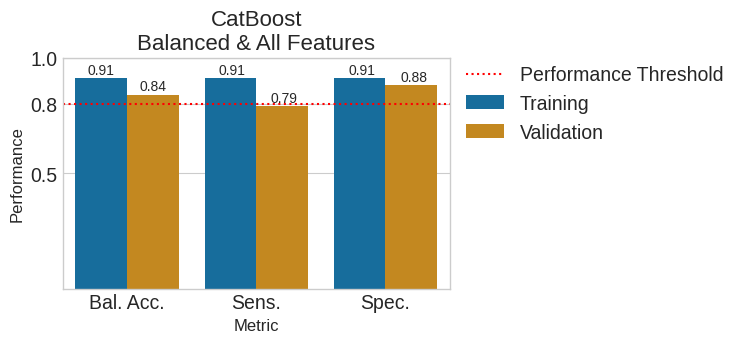

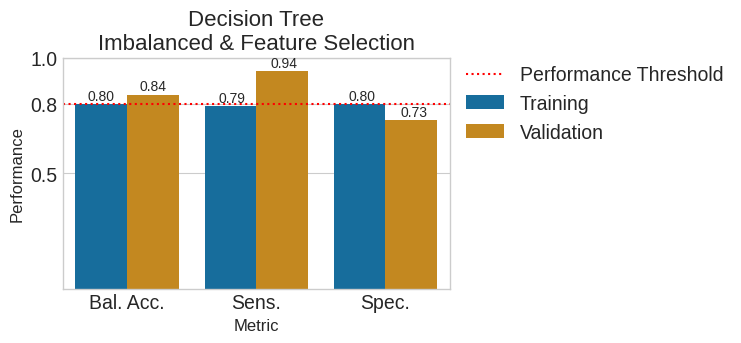

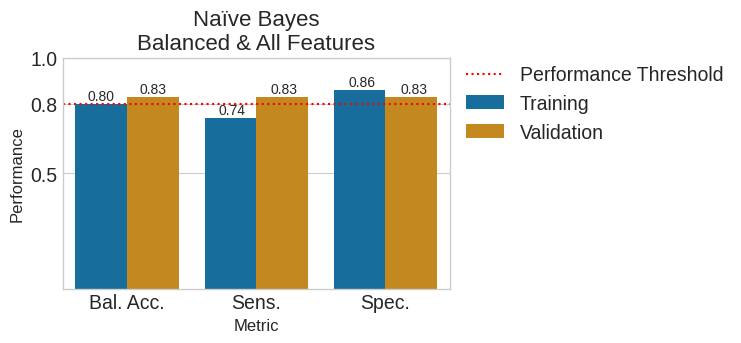

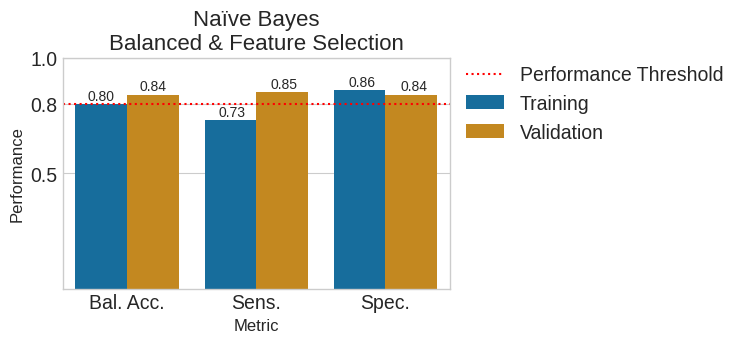

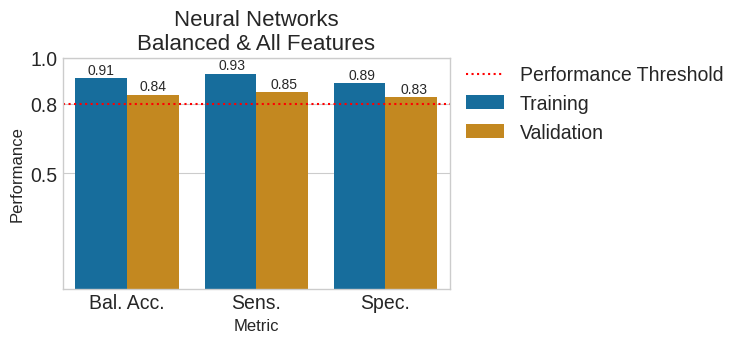

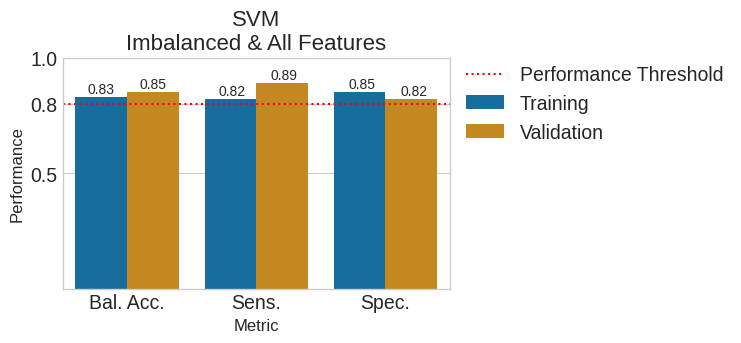

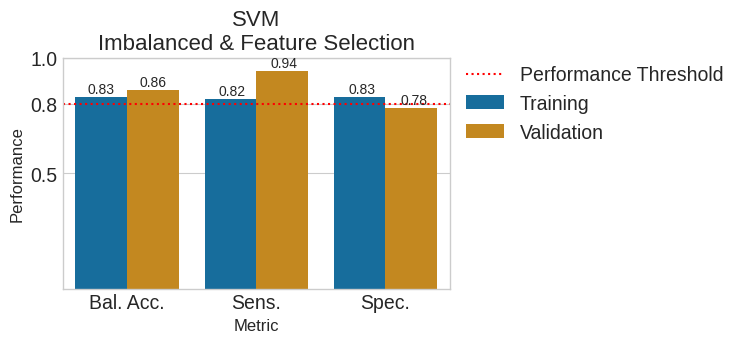

In [109]:
df_to_save = None


models = df_compare_train_valid.Model.unique()
datasets = df_compare_train_valid.Dataset.unique()
features = df_compare_train_valid.Features.unique()


# display performance as table for each model and scenario    
for model in models:
    dfs = []
    captions = []
    for dataset in datasets:
        for feature in features:
            df_temp = df_compare_train_valid.loc[
                (df_compare_train_valid.Model == model)
               &(df_compare_train_valid.Dataset  == dataset)
               &(df_compare_train_valid.Features == feature)
            ].copy()
            
            if df_temp.shape[0] > 0:
                
                if float(df_temp.Valid_Sens) >= 0.79:
                    plot_performances_comparing_train_validation(
                        df=df_temp, 
                        model=model,
                        figsize=[5, 3]
                    )
                    
                    if df_to_save is None:
                        df_to_save = df_temp.copy()
                    else:
                        df_to_save = pd.concat([df_to_save, df_temp])
  
#             break
#         break
#     break

    
# display(df_to_save)


### Save the best validation performance models

In [85]:
csv_file = os.path.abspath('exec_results/final_best_validation_models.csv')
utils.save_to_csv(df=df_to_save, csv_file=csv_file)

7 samples were saved


---
---
---
# OTHERS